In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from statsmodels.formula.api import ols
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

## Loading and Understanding the Data

In [9]:
data = pd.read_csv('healthcare_dataset.csv', delimiter=',', encoding='ISO-8859-1')
data = data.drop(columns=['Name', 'Doctor', 'Hospital'])
data = data.dropna().drop_duplicates()
data.columns

Index(['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission',
       'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type',
       'Discharge Date', 'Medication', 'Test Results'],
      dtype='object')

In [10]:
print(f'\n{data.info()}\n, \n{data.describe()}, \n{data.isnull().sum()}')

<class 'pandas.core.frame.DataFrame'>
Index: 54966 entries, 0 to 55499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 54966 non-null  int64  
 1   Gender              54966 non-null  object 
 2   Blood Type          54966 non-null  object 
 3   Medical Condition   54966 non-null  object 
 4   Date of Admission   54966 non-null  object 
 5   Insurance Provider  54966 non-null  object 
 6   Billing Amount      54966 non-null  float64
 7   Room Number         54966 non-null  int64  
 8   Admission Type      54966 non-null  object 
 9   Discharge Date      54966 non-null  object 
 10  Medication          54966 non-null  object 
 11  Test Results        54966 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 5.5+ MB

None
, 
                Age  Billing Amount   Room Number
count  54966.000000    54966.000000  54966.000000
mean      51.535185    25544.306284    

In [11]:
data['Date of Admission'] = pd.to_datetime(data['Date of Admission'])
data['Discharge Date'] = pd.to_datetime(data['Discharge Date'])
data['Length of Stay'] = (data['Discharge Date'] - data['Date of Admission']).dt.days
#data = data.drop(['Date of Admission', 'Discharge Date'], axis=1)

Distribution of Categorical Variables

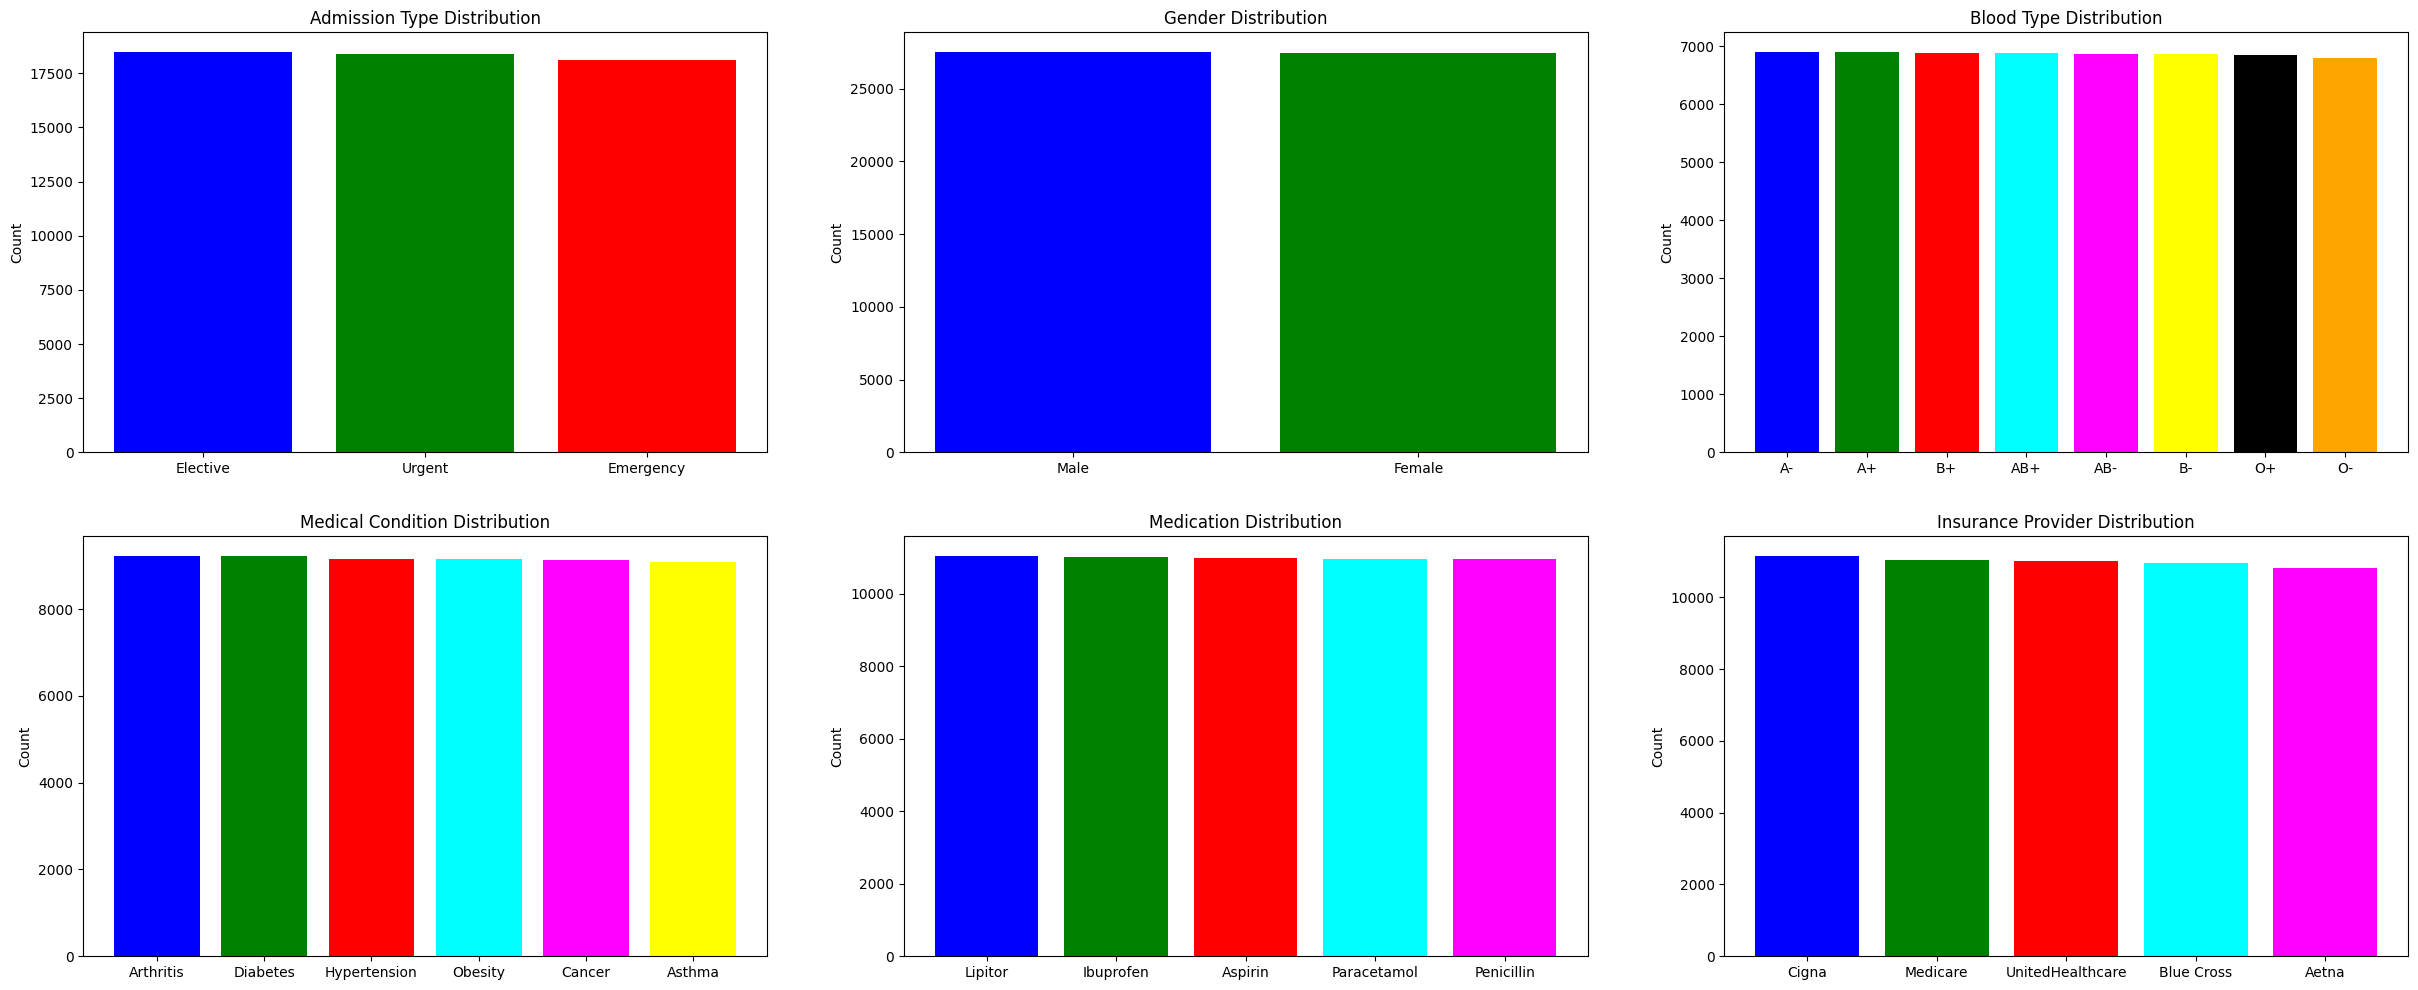

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 12))

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']
variables = ['Admission Type', 'Gender', 'Blood Type', 'Medical Condition', 'Medication', 'Insurance Provider', 'Test Results']
for ax, var in zip(axs.flatten(), variables):
    counts = data[var].value_counts()
    ax.bar(counts.index, counts.values, color=colors)
    ax.set_title(f'{var} Distribution')
    ax.set_ylabel('Count')

Distribution of Target Variable

([<matplotlib.patches.Wedge at 0x17f50fce0>,
 [Text(-1.0780379484906875, -0.4004175091251507, 'Abnormal'),
  Text(0.8909661931240512, -0.7271033232698334, 'Normal'),
  Text(0.19166395950969667, 1.1339157493504823, 'Inconclusive')],
 [Text(-0.6093257969729973, -0.2263229399403025, '33.5%'),
  Text(0.5035895874179419, -0.41097144358729715, '33.3%'),
  Text(0.10833180320113288, 0.6409089018067943, '33.1%')])

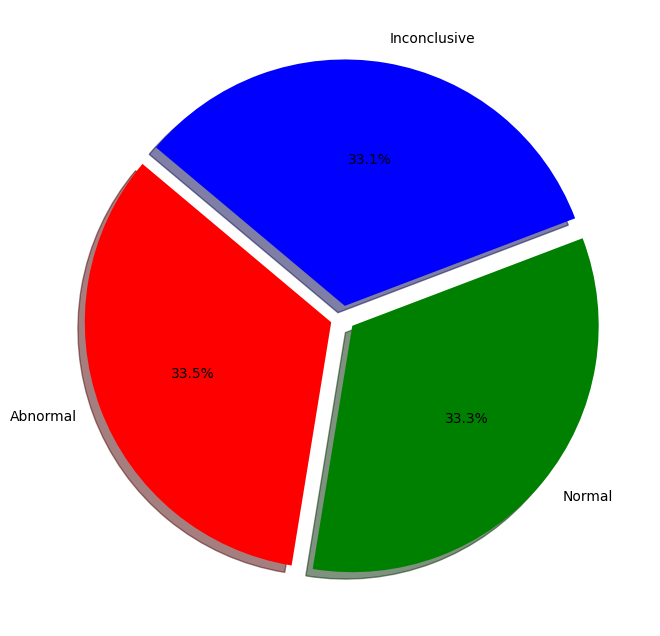

In [13]:
Test_Results_counts = data['Test Results'].value_counts()
df_Test_Results = pd.DataFrame({'Label':Test_Results_counts.index, 'Counts':Test_Results_counts.values})
plt.figure(figsize=(8, 8))
explode = [0.05] * len(df_Test_Results) 
colors = ['red', 'green', 'blue']  

plt.pie(df_Test_Results['Counts'], explode=explode, colors=colors[:len(df_Test_Results)], 
        labels=df_Test_Results['Label'], autopct='%1.1f%%', shadow=True, startangle=140)

Distribution of Numerical Variables

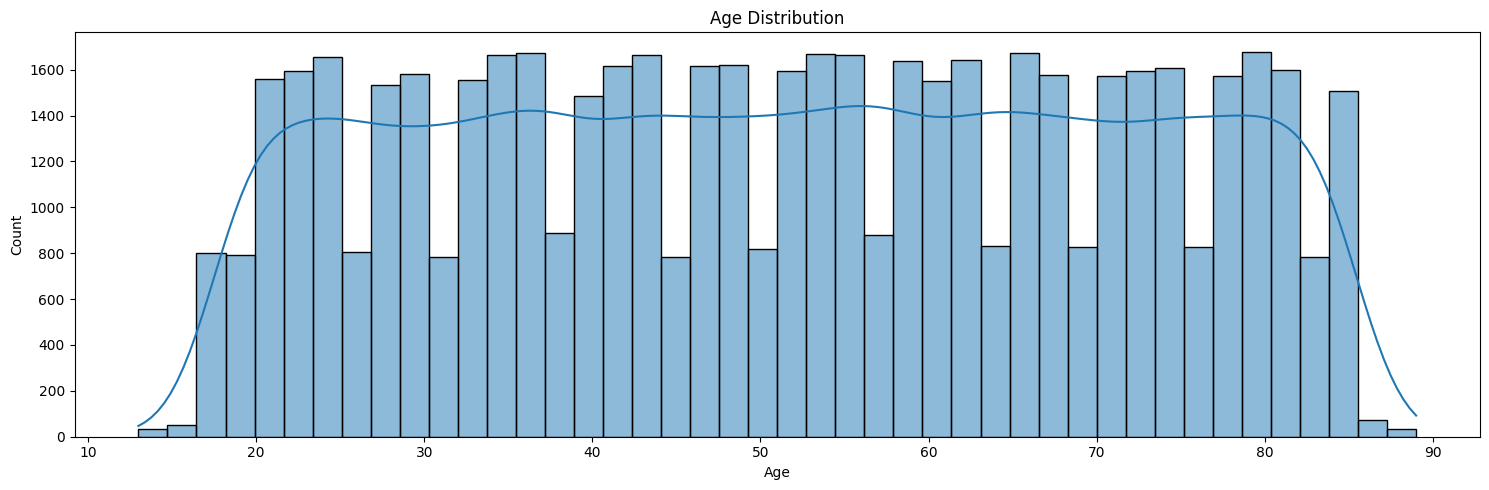

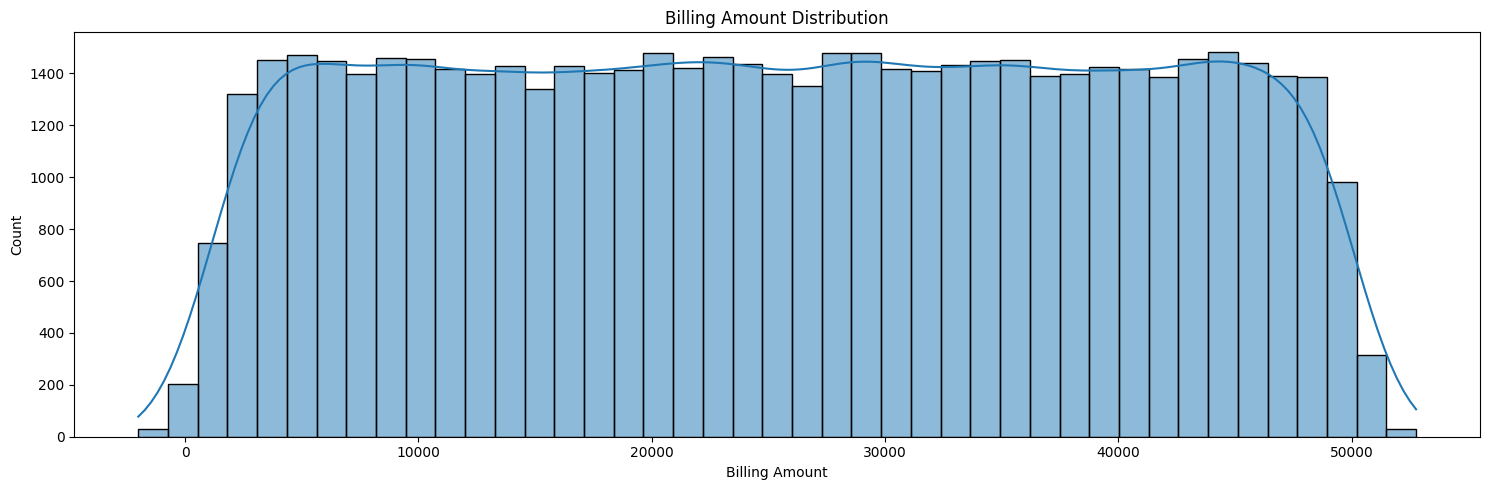

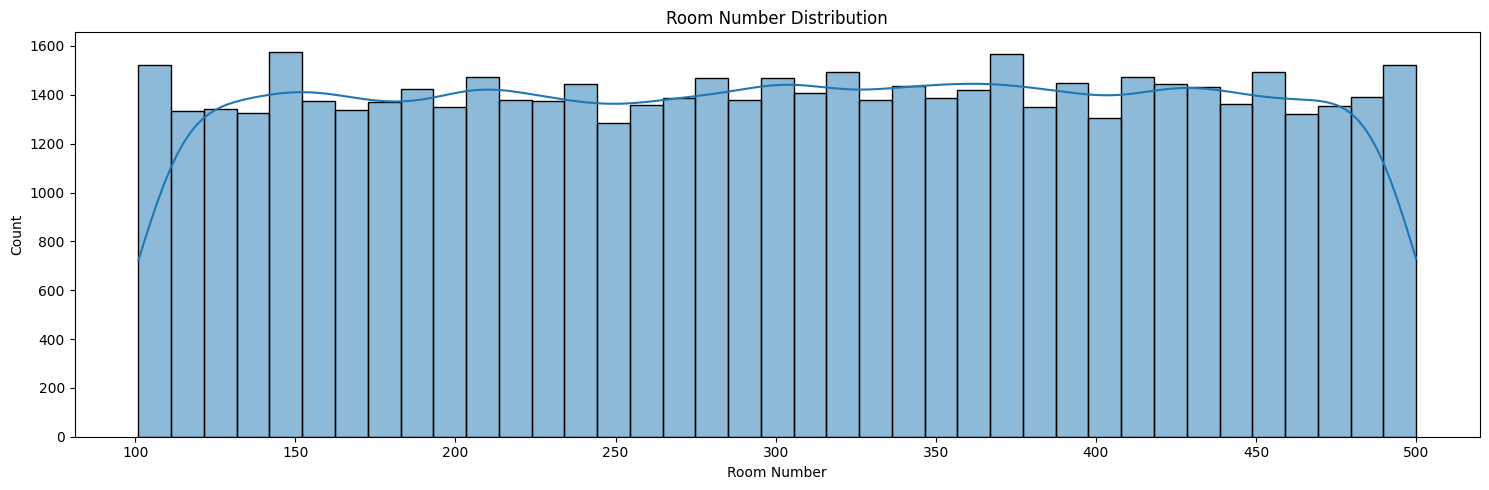

In [23]:
column = ['Age', 'Billing Amount', 'Room Number']

for c in column:
    plt.figure(figsize=(15,5))
    sns.histplot(data[c], kde=True)
    plt.title(f'{c} Distribution')

    plt.tight_layout()

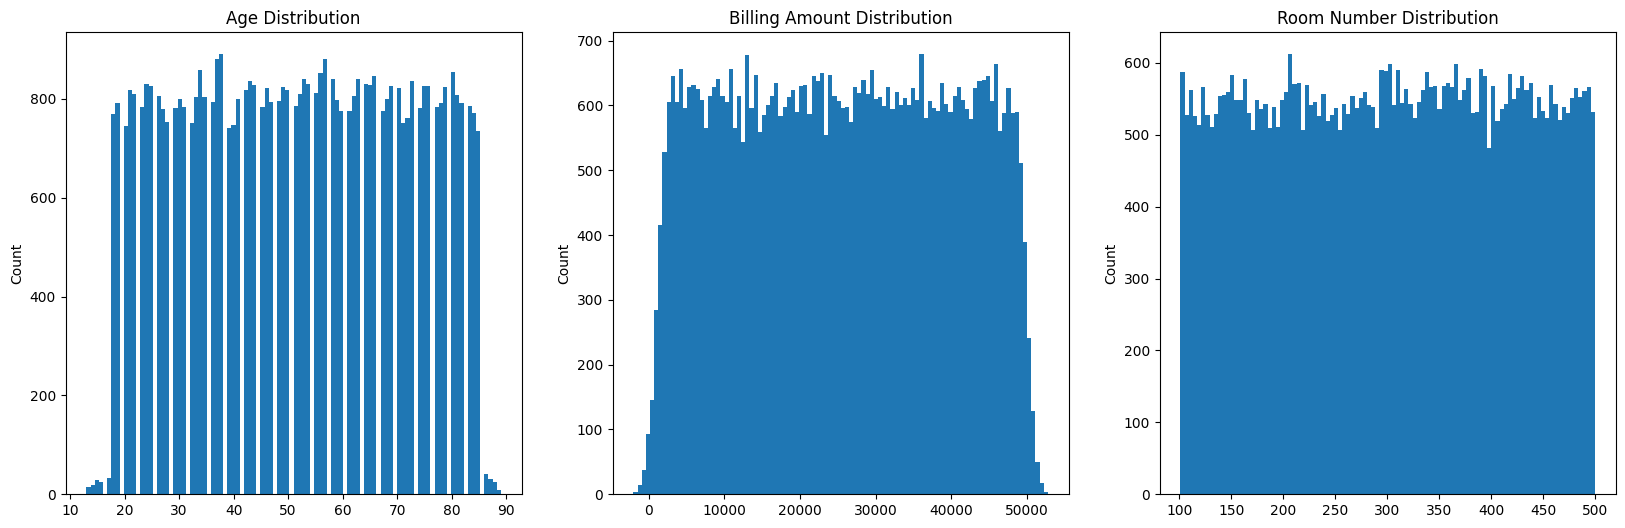

In [100]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

variables = ['Age', 'Billing Amount', 'Room Number']
for ax, var in zip(axs.flatten(), variables):
    ax.hist(data[var], 100)
    ax.set_title(f'{var} Distribution')
    ax.set_ylabel('Count')

/var/folders/sb/73j4d15s4k34y66s1tpvsgx80000gn/T/ipykernel_50504/793595638.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='Medical Condition', y='Age', palette='Set1')


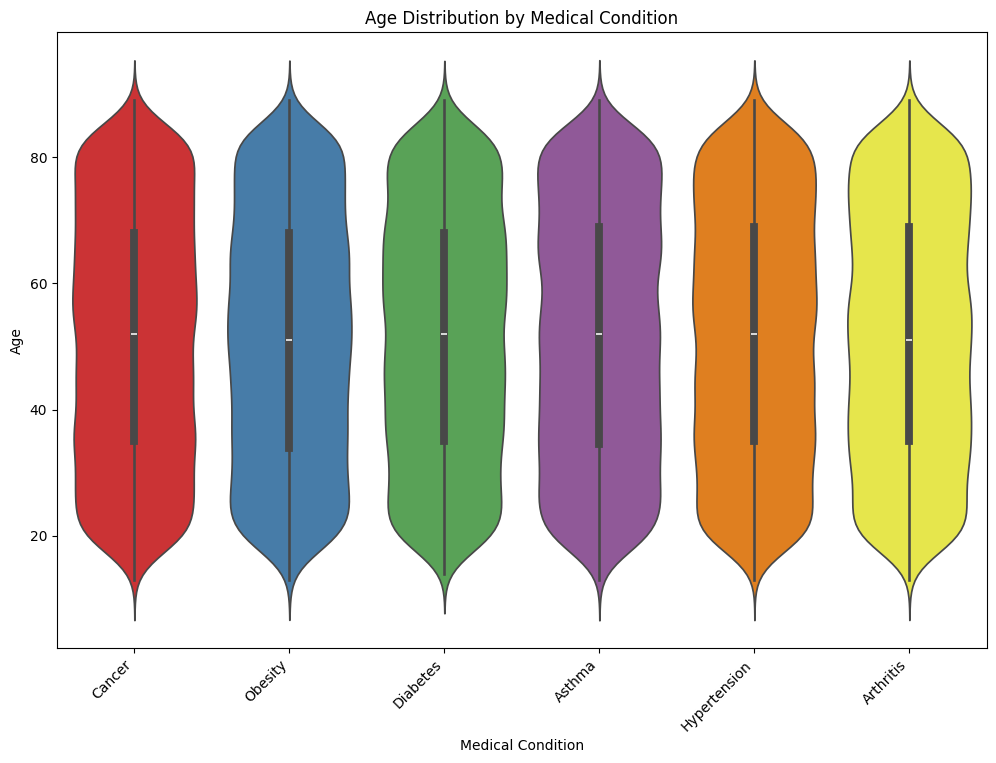

In [120]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=data, x='Medical Condition', y='Age', palette='Set1')
plt.title('Age Distribution by Medical Condition')
plt.xlabel('Medical Condition')
plt.ylabel('Age')
plt.xticks(rotation=45, ha='right')
plt.show()

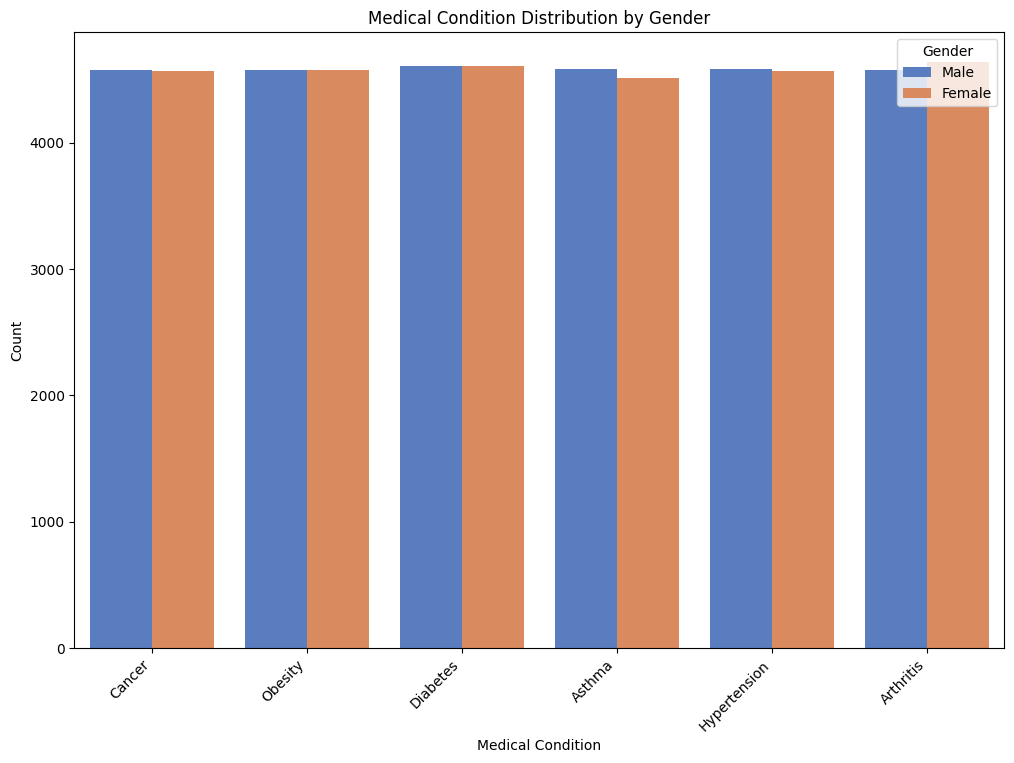

In [122]:
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='Medical Condition', hue='Gender', palette='muted')
plt.title('Medical Condition Distribution by Gender')
plt.xlabel('Medical Condition')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

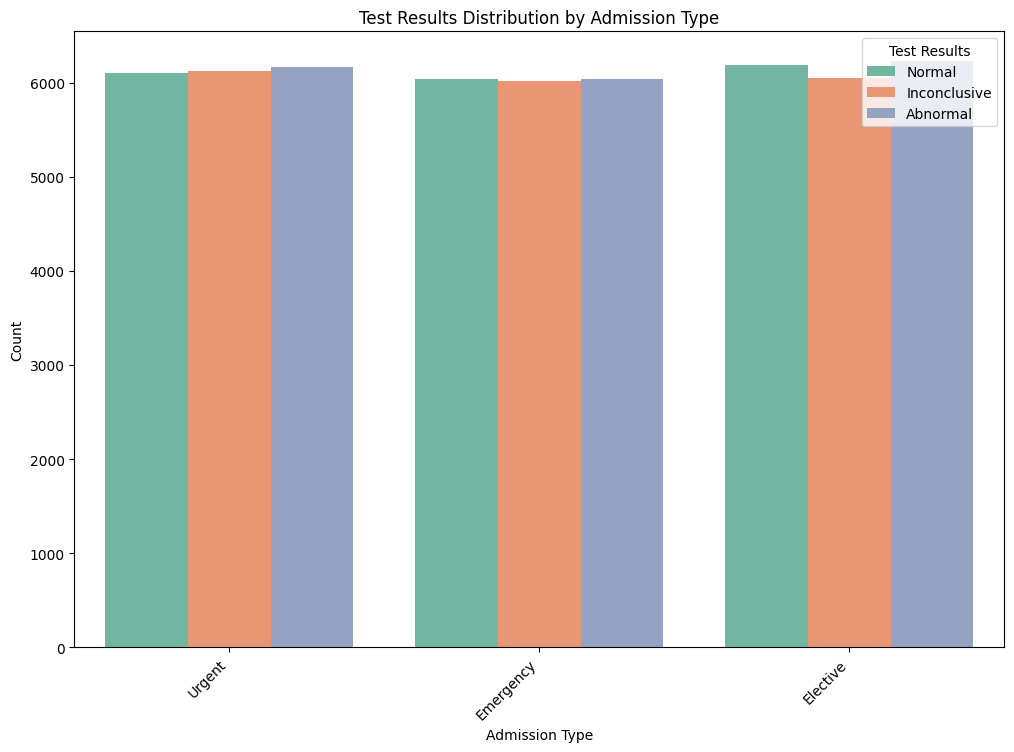

In [124]:
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='Admission Type', hue='Test Results', palette='Set2')
plt.title('Test Results Distribution by Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

## Exploratory Data Analysis (EDA)

Chi-Square test for categorical variables

In [101]:
categorical_cols = data.drop(columns=['Room Number', 'Billing Amount','Test Results','Age','Length of Stay'])

chi2_results = []
for feature in categorical_cols:
    contingency_table = pd.crosstab(data[feature], data['Test Results'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results.append((feature, chi2, p))

chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi-Square', 'P-Value'])
chi2_df.sort_values(by='P-Value', inplace=True)
print(f'Chi-Square test: \n{chi2_df}')

Chi-Square test: 
              Feature  Chi-Square   P-Value
2   Medical Condition   13.271595  0.208881
0              Gender    2.184632  0.335439
3  Insurance Provider    9.034619  0.339384
4      Admission Type    1.648354  0.800076
5          Medication    3.851882  0.870234
1          Blood Type    8.001800  0.889232


In [102]:
low_cardinality_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Medication']
high_cardinality_cols = ['Insurance Provider']

encoder = OneHotEncoder()
low_cardinality_cols_encoded = {}
encoder_names = []
for col in data[low_cardinality_cols]:
    low_cardinality_cols_encoded[col] = encoder.fit_transform(data[[col]]).toarray()
    encoder_names.extend(encoder.categories_)
column_names = [name for names in encoder_names for name in names]
encoded_arrays = [low_cardinality_cols_encoded[col] for col in low_cardinality_cols]
encoded_data = np.hstack(encoded_arrays)
encoded_df = pd.DataFrame(encoded_data, columns=column_names)

In [103]:
label_encoders = {}
for col in high_cardinality_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

In [104]:
Cleaned_data = pd.concat([data.drop(columns=low_cardinality_cols), encoded_df ], axis=1).dropna()
Cleaned_data.columns

Index(['Age', 'Insurance Provider', 'Billing Amount', 'Room Number',
       'Test Results', 'Length of Stay', 'Female', 'Male', 'A+', 'A-', 'AB+',
       'AB-', 'B+', 'B-', 'O+', 'O-', 'Arthritis', 'Asthma', 'Cancer',
       'Diabetes', 'Hypertension', 'Obesity', 'Elective', 'Emergency',
       'Urgent', 'Aspirin', 'Ibuprofen', 'Lipitor', 'Paracetamol',
       'Penicillin'],
      dtype='object')

In [105]:
column_to_rename = {'Test Results':'Test_Results', 'Billing Amount':'Billing_Amount', 'Room Number':'Room_Number', 
                    'Insurance Provider':'Insurance_Provider', 'Length of Stay':'Length_of_Stay'}
Cleaned_data = Cleaned_data.rename(columns=column_to_rename)

ANOVA Test for numerical variables

In [106]:
label_encoder = LabelEncoder()
Cleaned_data['Test_Results'] = label_encoder.fit_transform(Cleaned_data['Test_Results'])

model = ols('Test_Results ~ Billing_Amount + Age + Room_Number + Length_of_Stay', data=Cleaned_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(f'Anova Test \n{anova_table}')

Anova Test 
                      sum_sq       df         F    PR(>F)
Billing_Amount      0.349149      1.0  0.521859  0.470053
Age                 2.113368      1.0  3.158772  0.075526
Room_Number         0.208630      1.0  0.311831  0.576561
Length_of_Stay      0.096466      1.0  0.144184  0.704158
Residual        36453.050928  54485.0       NaN       NaN


# Correlation metrix chart

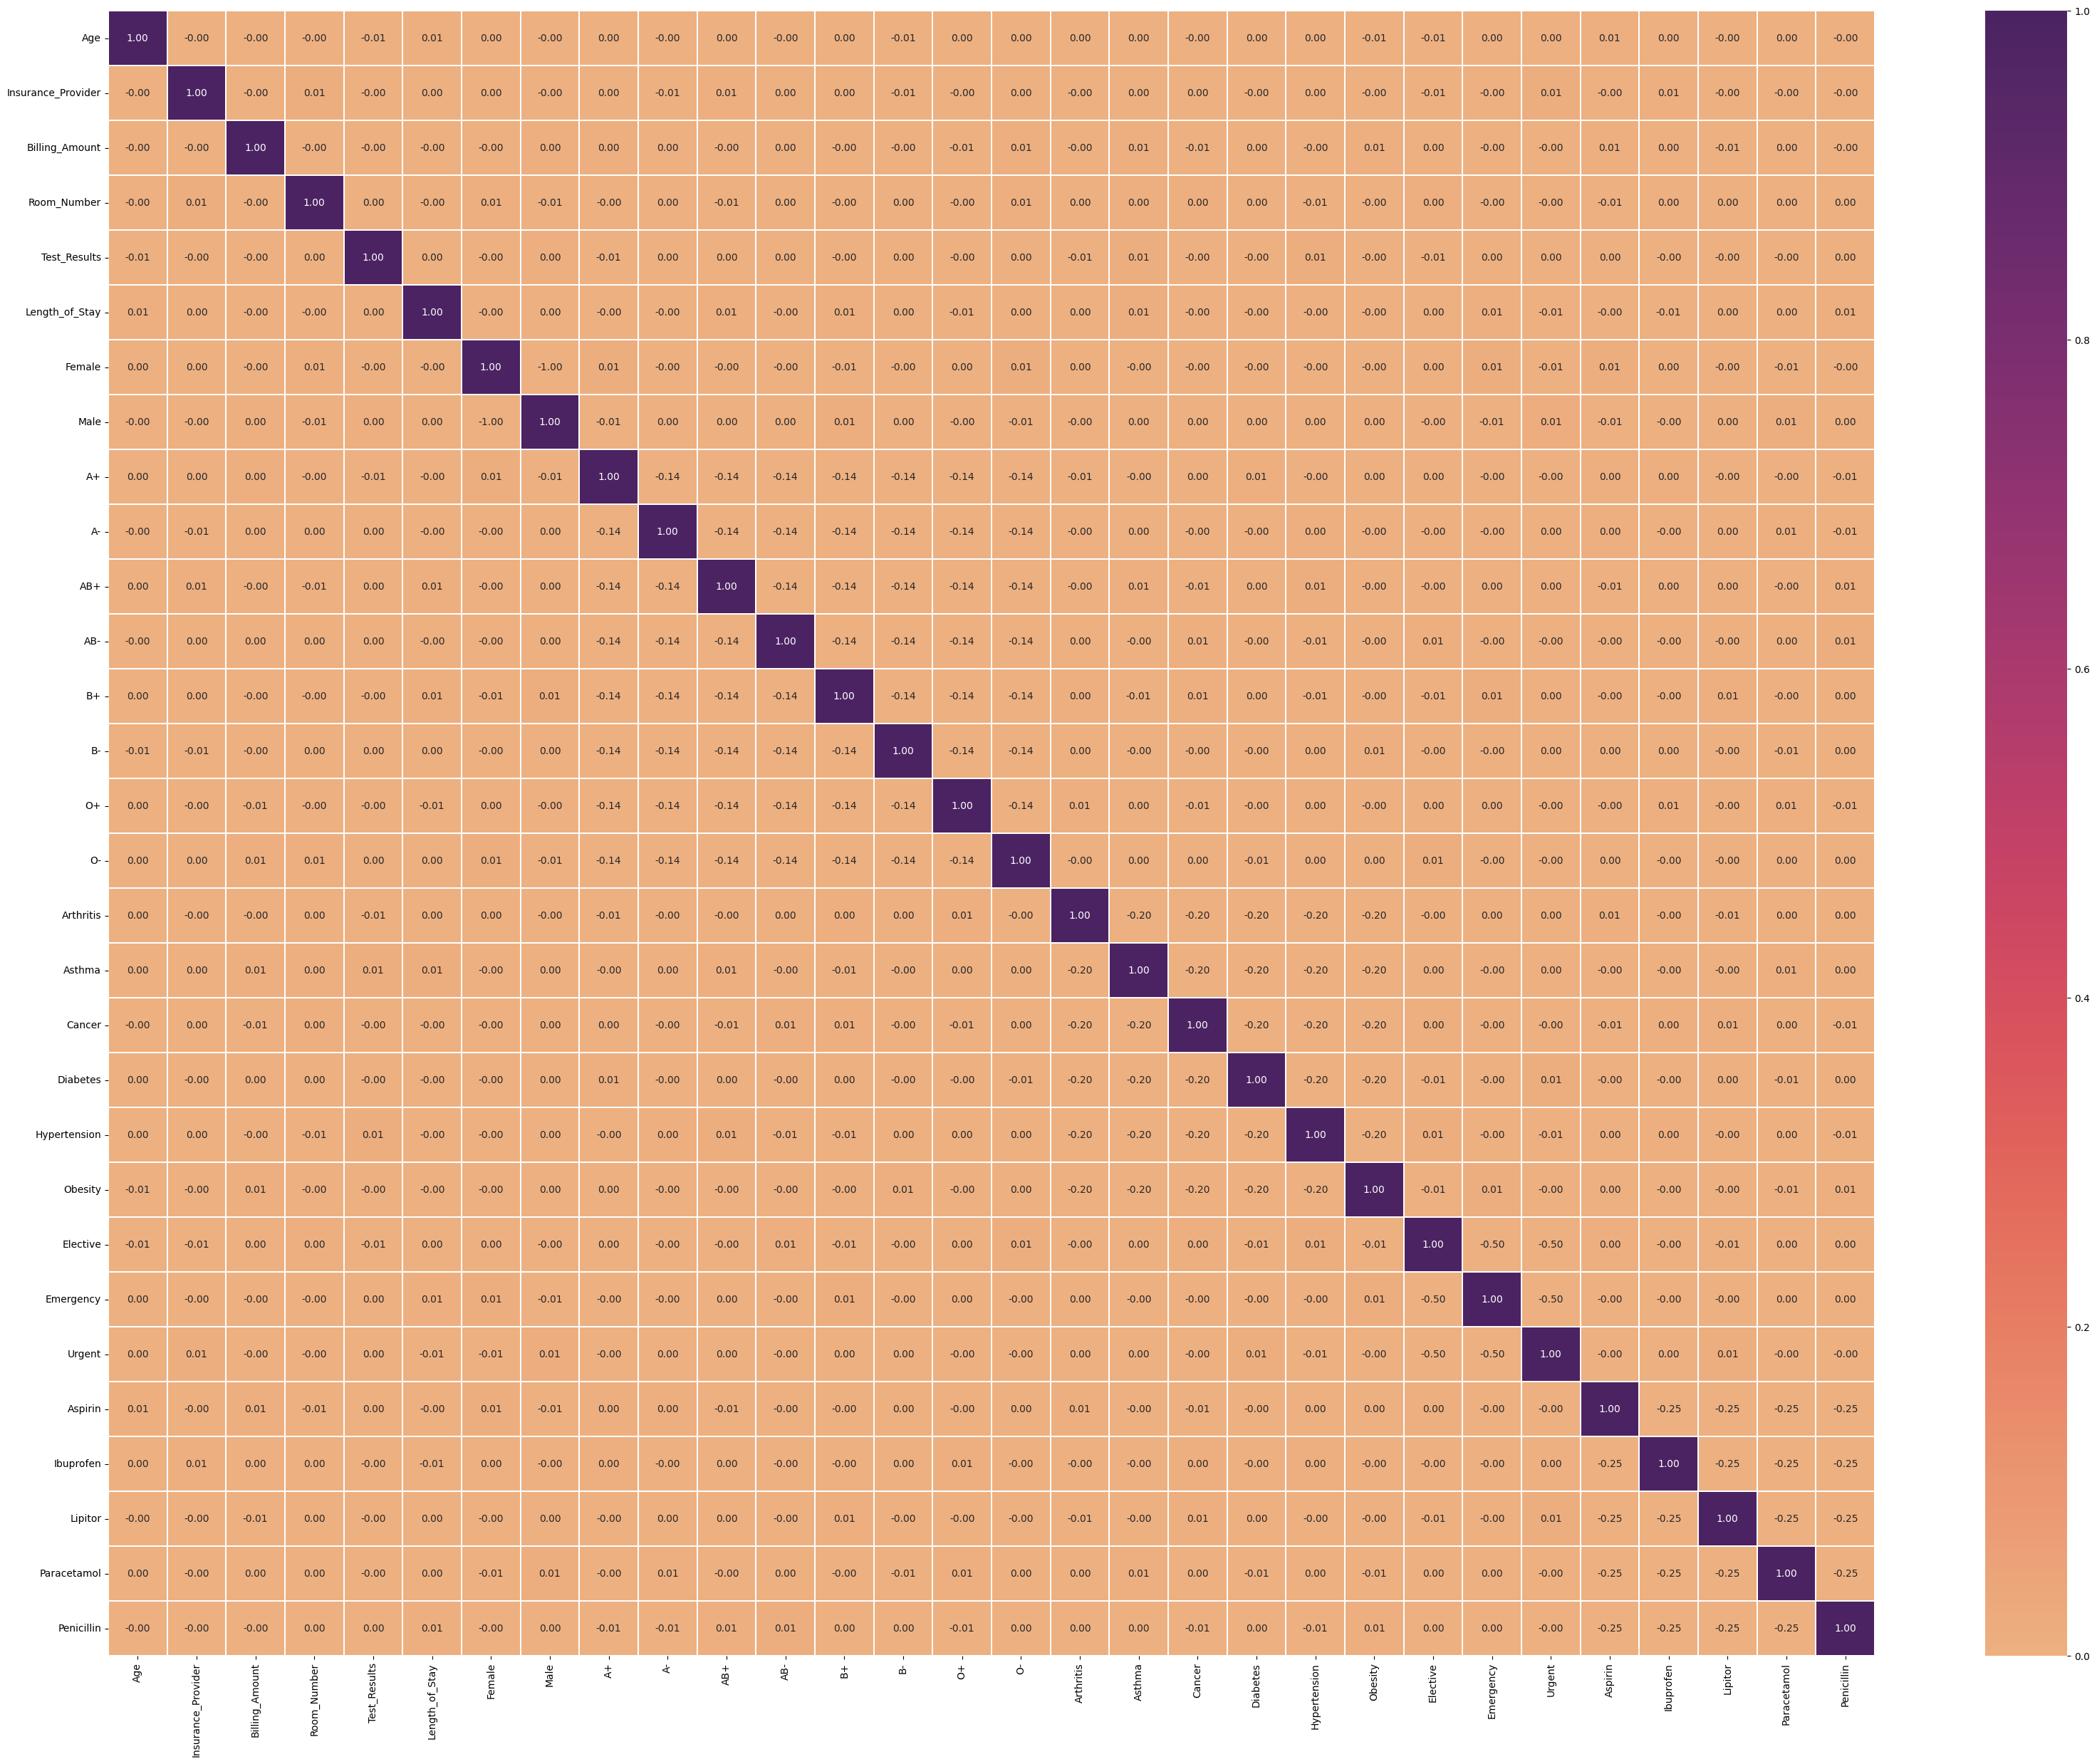

In [107]:
plt.figure(figsize=(40,30))
corr = Cleaned_data.corr()
sns.heatmap(corr, annot=True, linewidth=.1, vmin=0, vmax=1,
            fmt=".2f", cmap=sns.color_palette("flare", as_cmap=True))
plt.show()

## Principal Component Analysis (PCA)

In [111]:
Cleaned_data = Cleaned_data.sample(n=500, random_state=42)
Cleaned_data['Test_Results'] = data['Test Results']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(Cleaned_data.drop(columns='Test_Results'))

features = pd.DataFrame(scaled_data, columns=Cleaned_data.drop(columns='Test_Results').columns)

pca = PCA(n_components=20, random_state=42)
pca_data = pca.fit_transform(features)
pca_data

array([[ 1.59704028, -1.39071748, -1.00119681, ..., -0.28525386,
        -1.23590294,  1.02851742],
       [-1.6311835 ,  2.62342813, -1.13657356, ...,  0.20456644,
         1.83859249,  0.50448433],
       [ 1.13655111, -1.29689018, -1.18272639, ...,  0.00562946,
        -0.02012803, -1.10539596],
       ...,
       [ 1.71506153, -0.94769065, -1.61645314, ..., -0.89799387,
         0.38987833, -0.53396144],
       [ 0.80852356, -1.23750533, -1.67279703, ..., -0.64784586,
        -1.09392724,  0.58825014],
       [-2.20122949, -1.80373316, -1.70052925, ...,  0.92483532,
        -1.12136041,  0.15966229]])

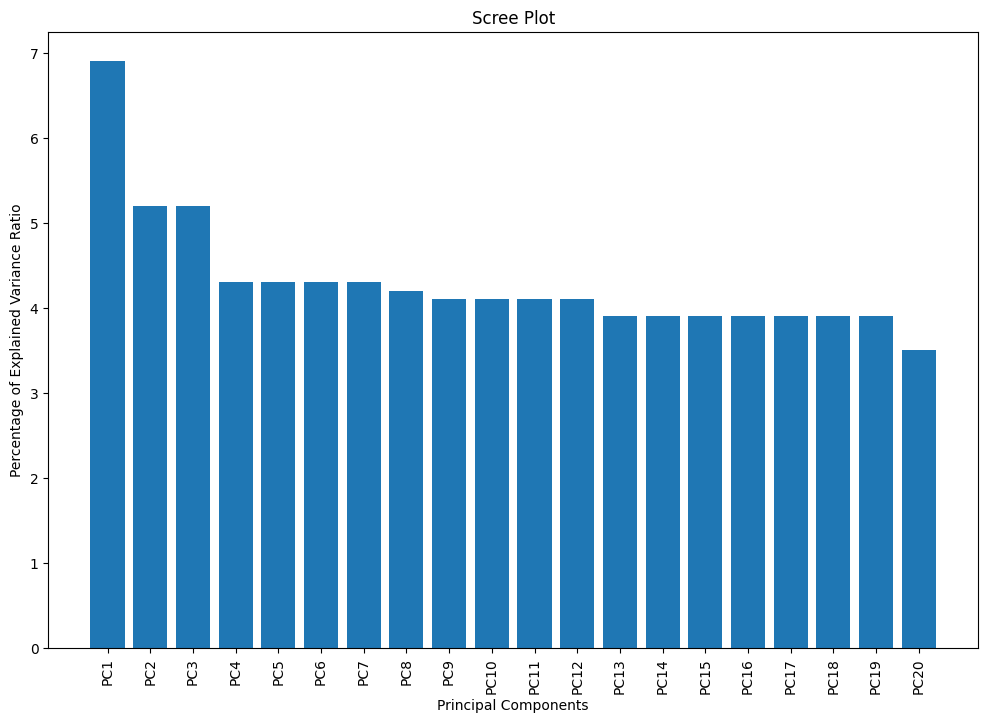

In [109]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.figure(figsize=(12, 8))
plt.bar(range(1, len(per_var) + 1), height=per_var)

plt.ylabel('Percentage of Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.xticks(ticks=range(1, len(labels) + 1), labels=labels, rotation=90)
plt.show()

## Multi Model Test & Evaluation

Using KFold strategy: StratifiedKFold_3
Classifier: SVC
Fitting 3 folds for each of 320 candidates, totalling 960 fits
Best Score: 0.34399721633764185
Best Parameters: {'svc__C': 10, 'svc__degree': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

    Abnormal       0.33      0.06      0.10        33
Inconclusive       0.33      0.03      0.05        39
      Normal       0.30      0.96      0.45        28

    accuracy                           0.30       100
   macro avg       0.32      0.35      0.20       100
weighted avg       0.32      0.30      0.18       100

---------------------------------------------------------------------------
Classifier: RandomForestClassifier
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Score: 0.3553135202071372
Best Parameters: {'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 1}
              precision    recall  f

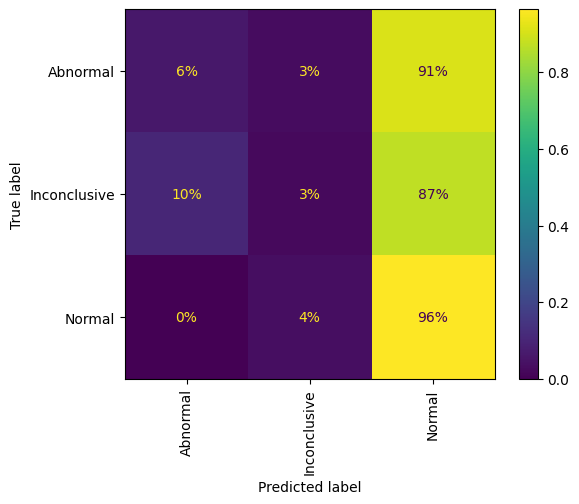

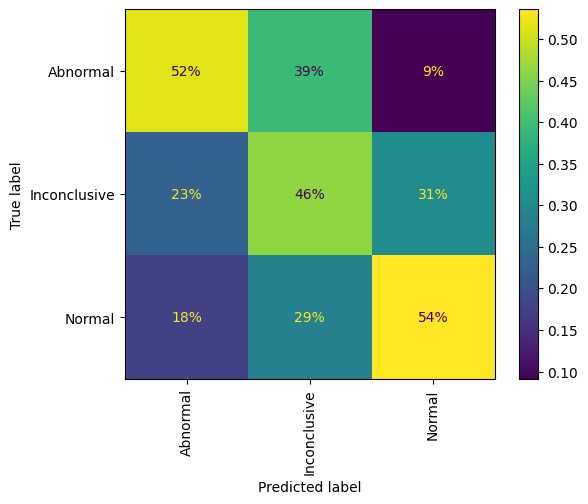

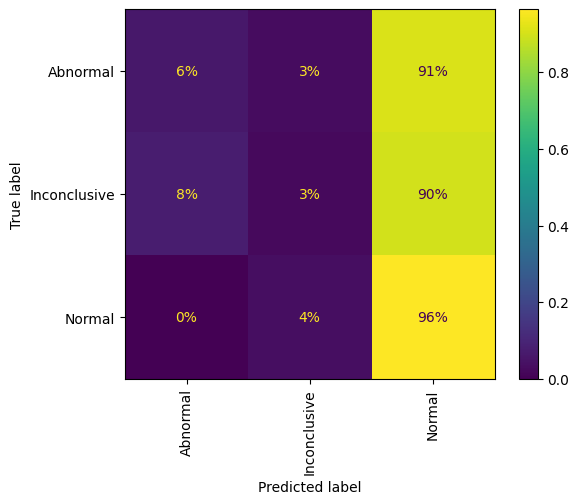

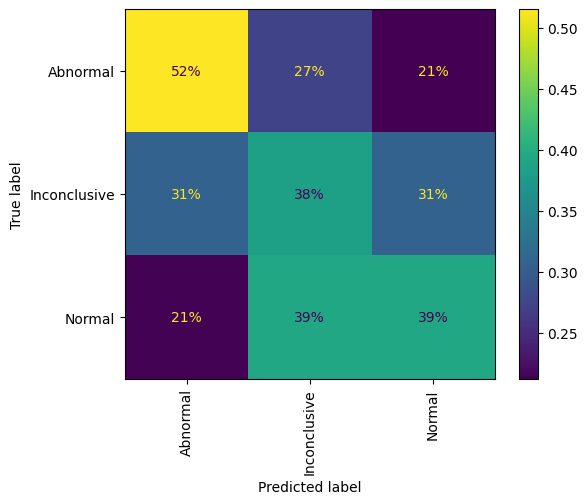

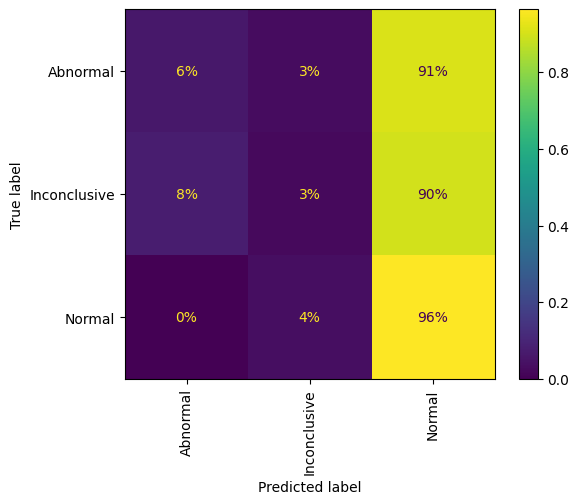

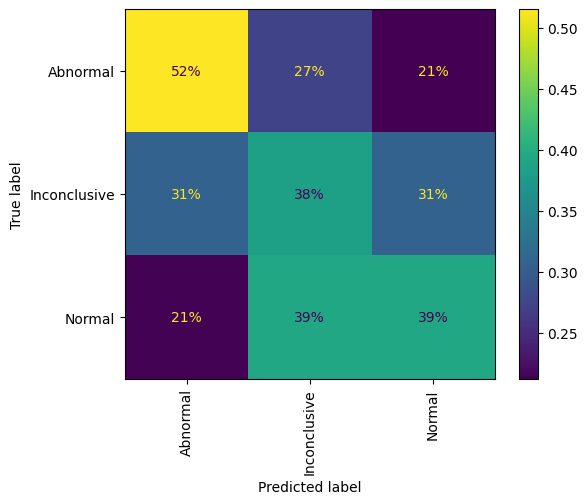

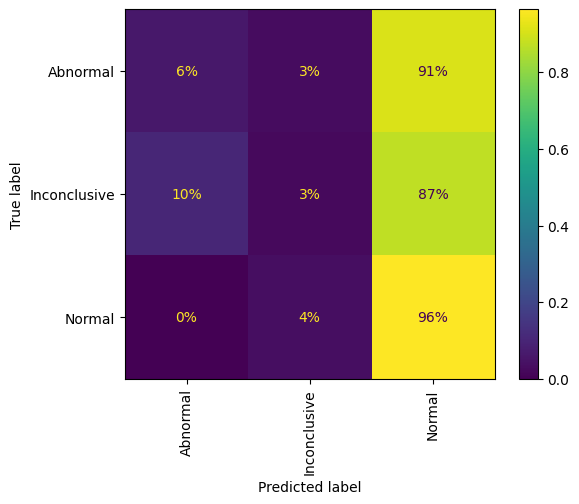

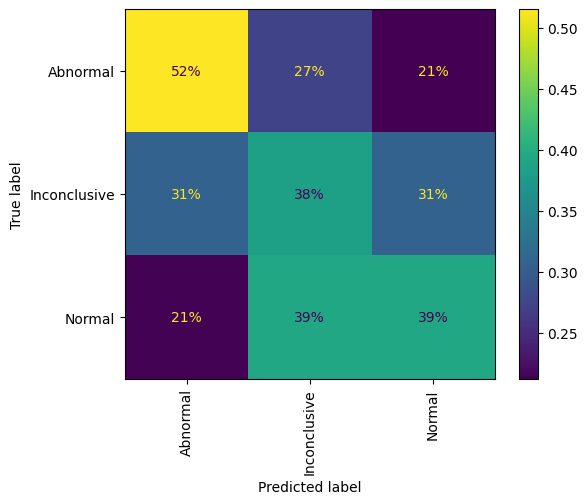

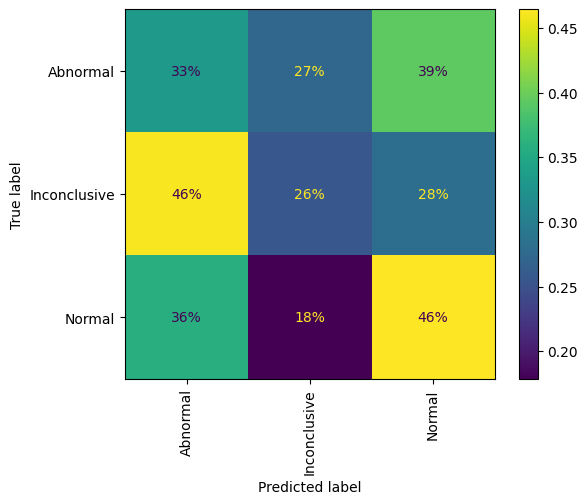

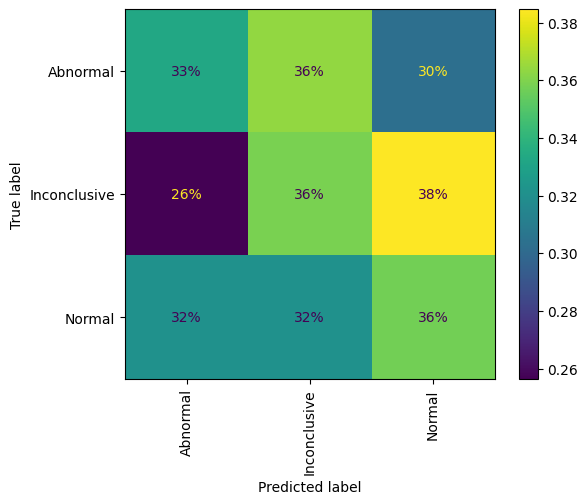

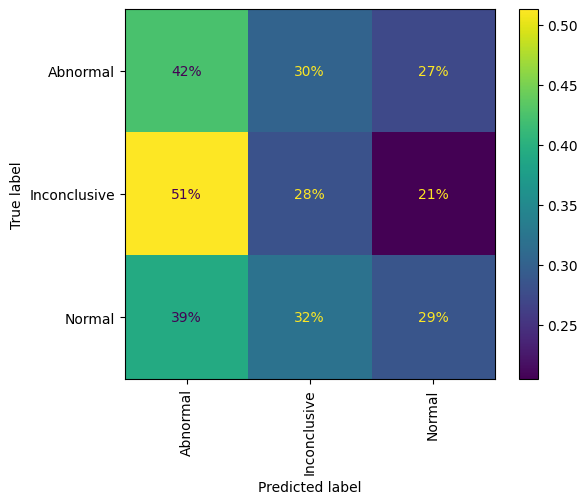

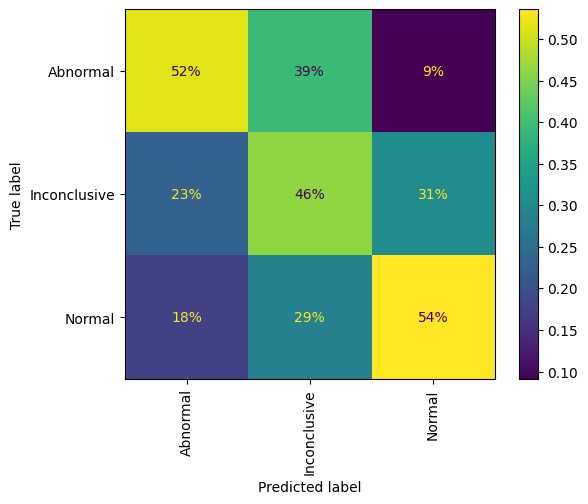

In [112]:
Cleaned_data = Cleaned_data.sample(n=500, random_state=42)
Cleaned_data['Test_Results'] = data['Test Results']

pca_data_df = pd.DataFrame(pca_data, columns=labels)
y = Cleaned_data['Test_Results']

# Split the data before any preprocessing
X_train, X_test, y_train, y_test = train_test_split(pca_data_df, y, test_size=0.20, random_state=42)

# Create pipelines for each classifier to eliminate data leakage 
svc_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', random_state=42))
])

rf_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])


# Define classifiers
classifiers = {
    'SVC': svc_pipeline,
    'RandomForestClassifier': rf_pipeline
}

# Define hyperparameters
params = {
    'SVC': {
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'svc__degree': [1, 2, 3, 4],
        'svc__C': [1, 10, 100, 200, 300],
        'svc__gamma': [0.1, 0.01, 0.001, 1]
    },
    'RandomForestClassifier': {
        'rf__n_estimators': [1, 10, 100, 200, 500, 600],
        'rf__max_depth': [10, 50, 100, 200, 400, 500],
        'rf__bootstrap': [True],
        'rf__max_features': ['sqrt', 'log2'],
        'rf__criterion': ['gini', 'entropy']
    }
}
# Define different KFold strategies
kfold_strategies = {
    'StratifiedKFold_3': StratifiedKFold(n_splits=3),
    'StratifiedKFold_5': StratifiedKFold(n_splits=5),
    'StratifiedKFold_10': StratifiedKFold(n_splits=10),
    'KFold_3': KFold(n_splits=3, shuffle=True, random_state=42),
    'KFold_5': KFold(n_splits=5, shuffle=True, random_state=42),
    'KFold_10': KFold(n_splits=10, shuffle=True, random_state=42),
}

# Perform cross-validation and grid search
for kfold_name, kfold_strategy in kfold_strategies.items():
    print(f'Using KFold strategy: {kfold_name}')

    for name, clf in classifiers.items():
        print(f'Classifier: {name}')
        grid_best_model = GridSearchCV(estimator=clf, param_grid=params[name], scoring='balanced_accuracy', n_jobs=-1, 
                                        cv=kfold_strategy, verbose=1)

        grid_best_model.fit(X_train, y_train)

        y_pred = grid_best_model.predict(X_test)

        print(f'Best Score: {grid_best_model.best_score_}')
        print(f'Best Parameters: {grid_best_model.best_params_}')

        metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', values_format=".0%", xticks_rotation='vertical')
        print(metrics.classification_report(y_test, y_pred))
        print('-' * 75)